In [10]:
import os
import numpy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
import optuna
from itertools import cycle
import seaborn as sns
import statsmodels.api as sm 
from scipy.interpolate import interp1d
from prophet import Prophet

pd.set_option('display.max_columns', 50)
plt.style.use('bmh')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [11]:
%%time
oj = os.path.join
INPUT_DIR = '../input/m5-forecasting-accuracy/'
train = pd.read_csv(oj(INPUT_DIR, 'trainset.csv'))
price = pd.read_csv(oj(INPUT_DIR, 'sell_prices.csv'))
calendar = pd.read_csv(oj(INPUT_DIR, 'calendar.csv'))

sample_submit = pd.read_csv(oj(INPUT_DIR, 'submit.csv'))

CPU times: user 8.35 s, sys: 2.26 s, total: 10.6 s
Wall time: 16 s


In [12]:
print(calendar['event_type_1'].unique())

[nan 'Sporting' 'Cultural' 'National' 'Religious']


In [6]:
print(calendar['event_name_2'].unique())

[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


In [7]:
print(calendar['event_type_2'].unique())

[nan 'Cultural' 'Religious']


In [8]:
print(price.head())
print(price.shape)

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26
(6841121, 4)


In [5]:
print(train.shape)

(30490, 1933)


In [13]:
holidays = calendar[['date', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']]
holidays = holidays.rename(columns={'date': 'ds'})
holidays['lower_window'] = 0
holidays['upper_window'] = 1
holidays1 = holidays.dropna(subset = ['event_name_1'])
holidays2 = holidays.dropna(subset = ['event_name_2'])
holidays1 = holidays1[['ds', 'lower_window', 'upper_window', 'event_name_1']]
holidays1 = holidays1.rename(columns={'event_name_1': 'holiday'})
holidays2 = holidays2[['ds', 'lower_window', 'upper_window', 'event_name_2']]
holidays2 = holidays2.rename(columns={'event_name_2': 'holiday'})
holidays = pd.concat((holidays1, holidays2))
holidays = holidays.reset_index(drop=True)
print(holidays.head())


           ds  lower_window  upper_window        holiday
0  2011-02-06             0             1      SuperBowl
1  2011-02-14             0             1  ValentinesDay
2  2011-02-21             0             1  PresidentsDay
3  2011-03-09             0             1      LentStart
4  2011-03-16             0             1      LentWeek2


/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:47:58 - cmdstanpy - INFO - Chain [1] start processing
22:47:58 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


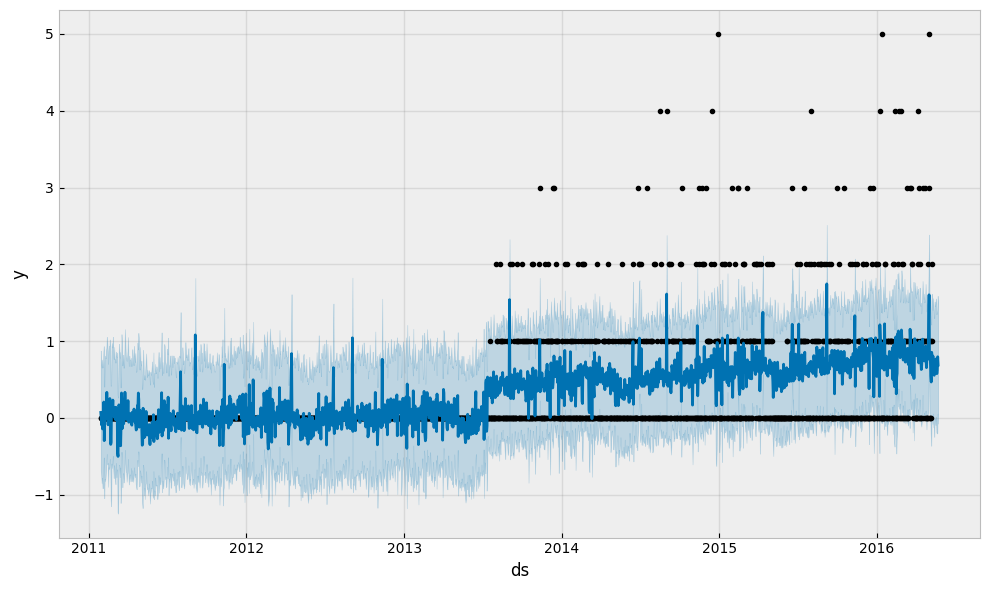

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:48:04 - cmdstanpy - INFO - Chain [1] start processing
22:48:04 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


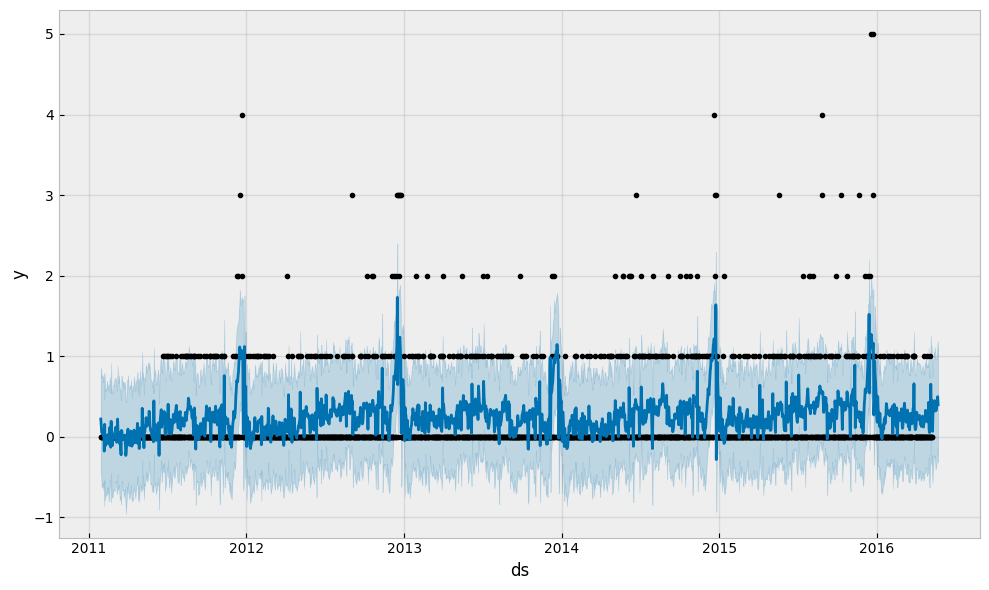

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:48:10 - cmdstanpy - INFO - Chain [1] start processing
22:48:11 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


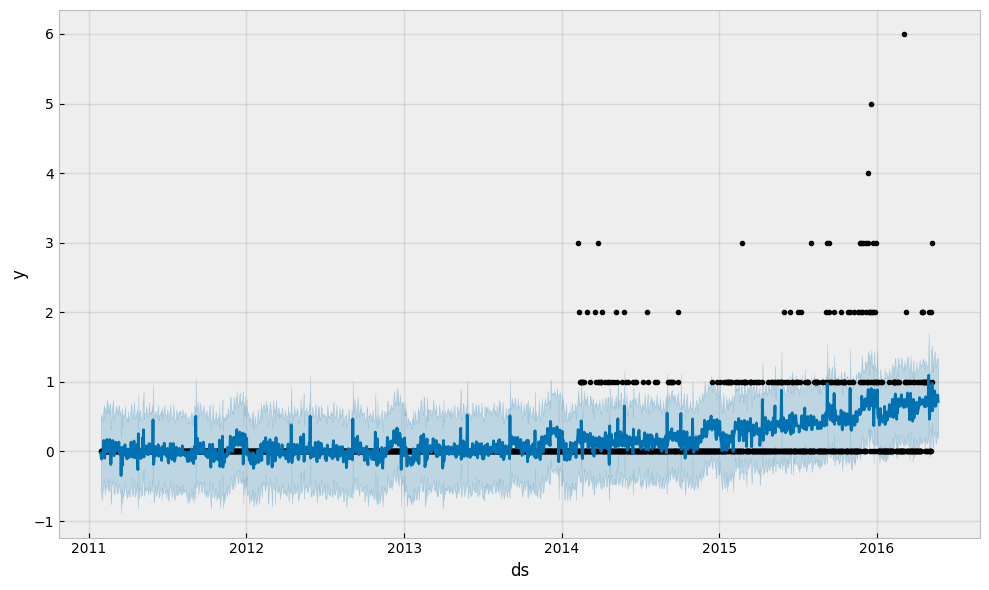

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:48:16 - cmdstanpy - INFO - Chain [1] start processing
22:48:16 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


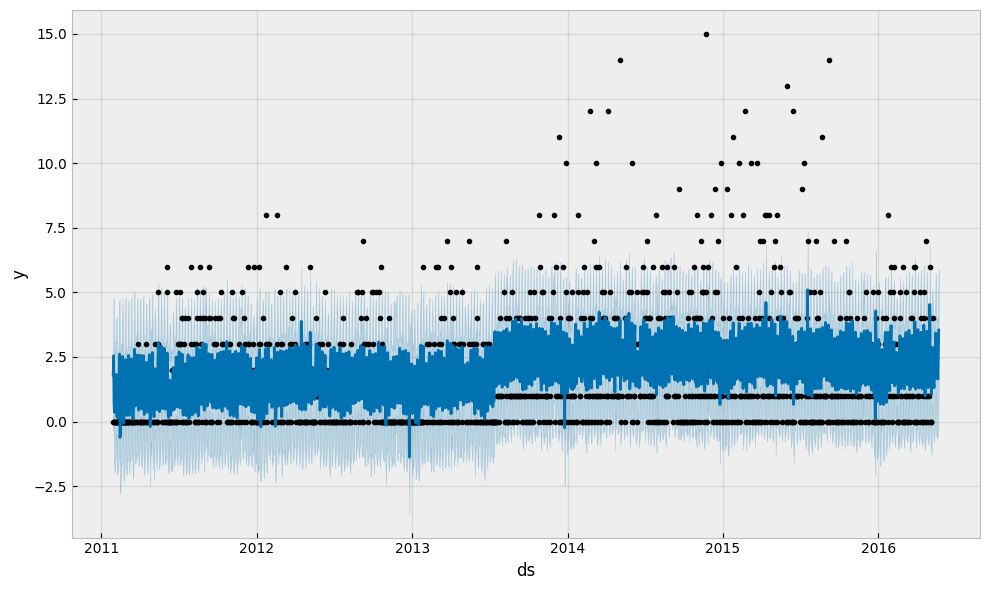

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


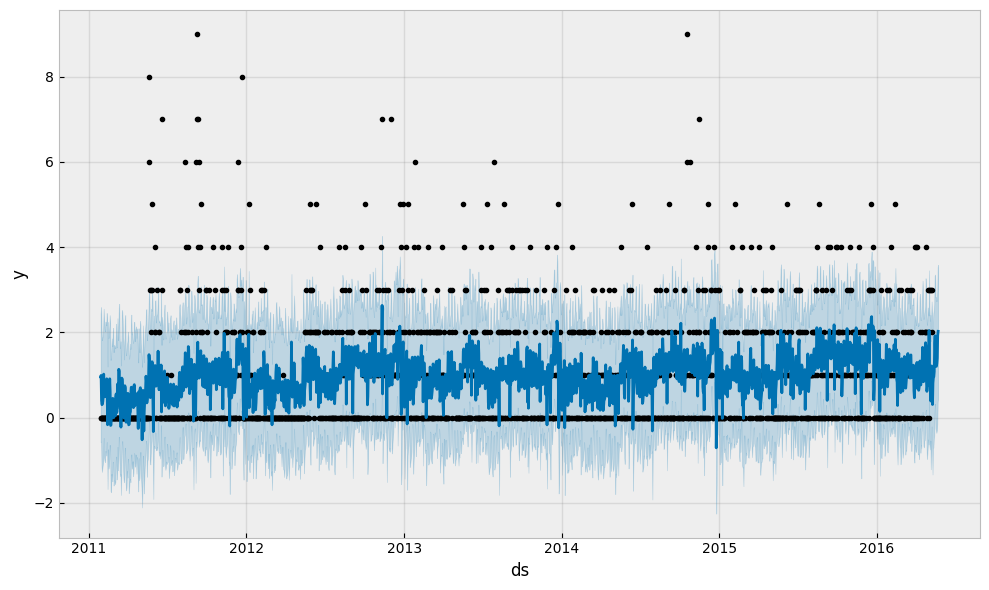

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


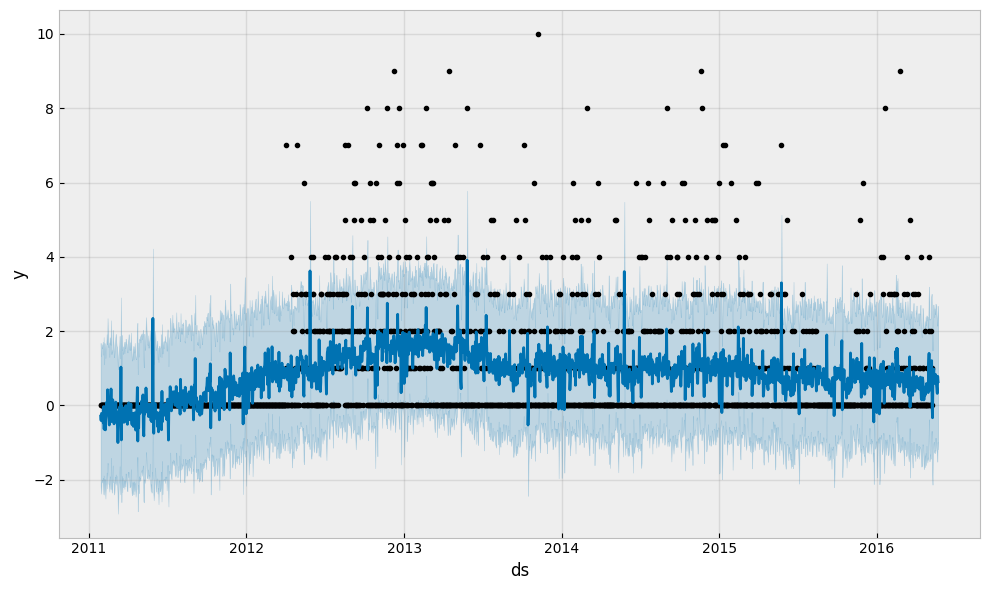

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


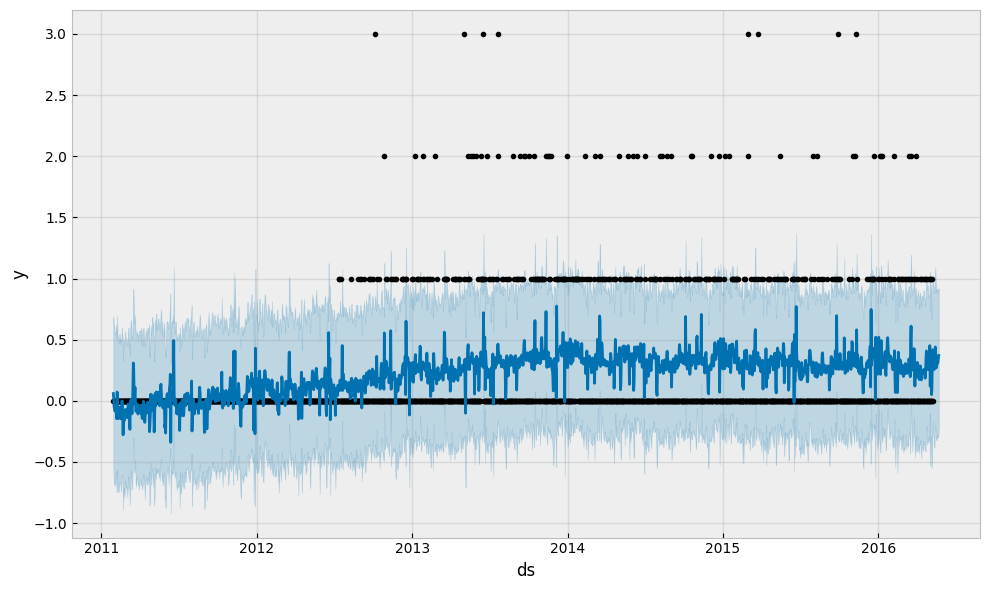

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2   y  
0             NaN  12  
1  

22:48:39 - cmdstanpy - INFO - Chain [1] start processing
22:48:40 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


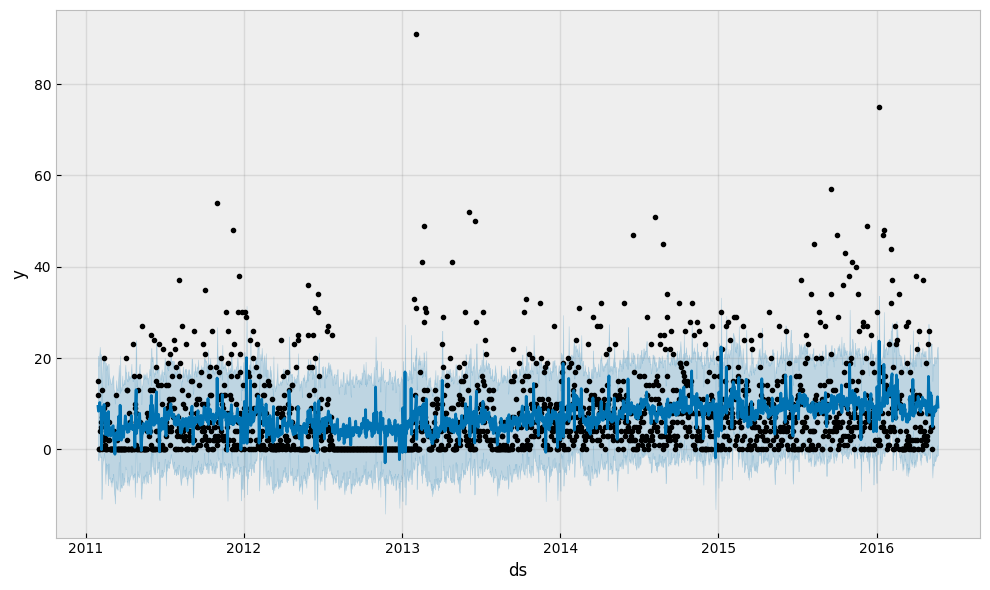

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  2  
1    

22:48:45 - cmdstanpy - INFO - Chain [1] start processing
22:48:45 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


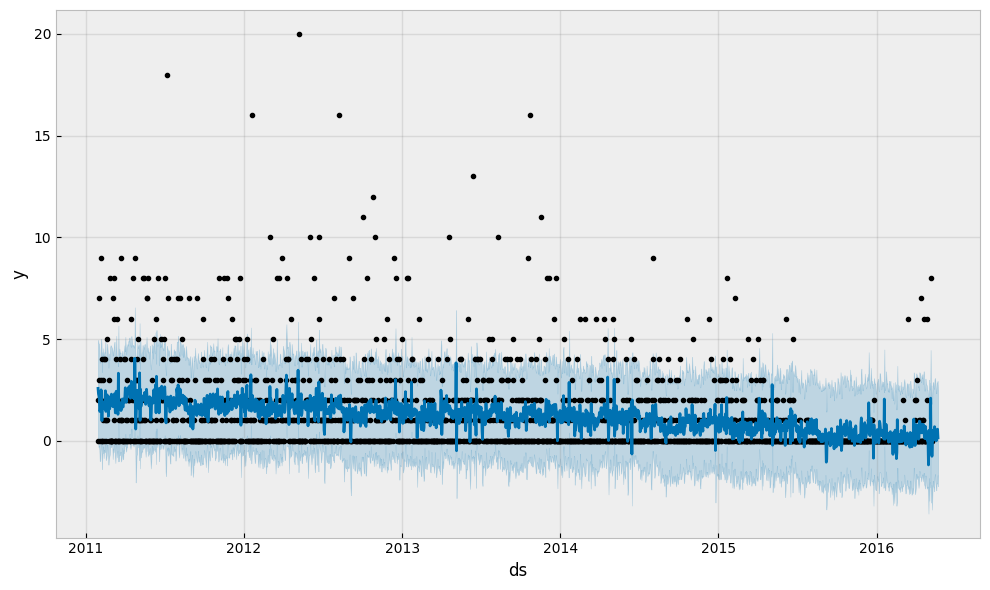

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:48:51 - cmdstanpy - INFO - Chain [1] start processing
22:48:51 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


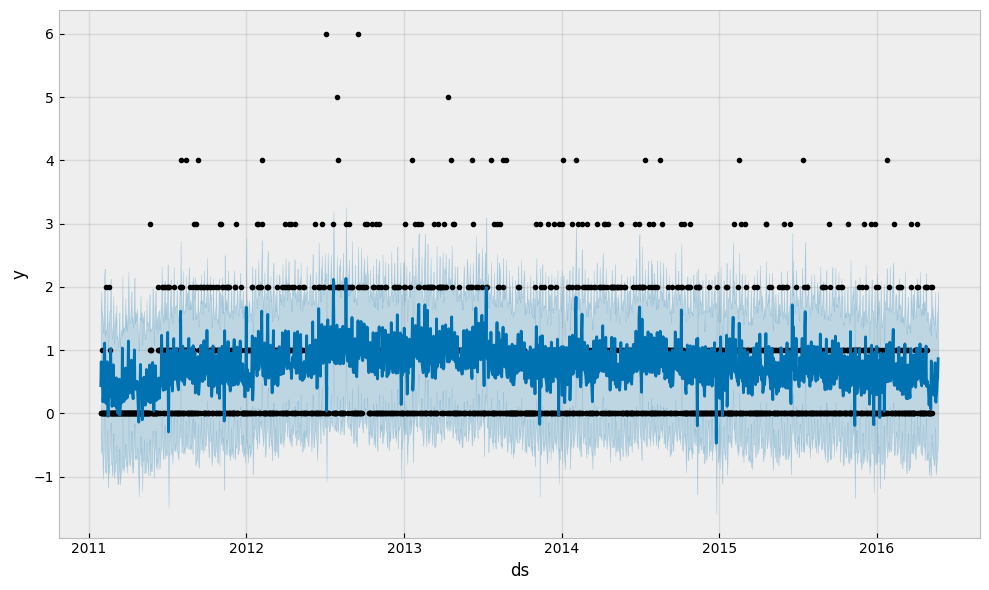

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:48:56 - cmdstanpy - INFO - Chain [1] start processing
22:48:57 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


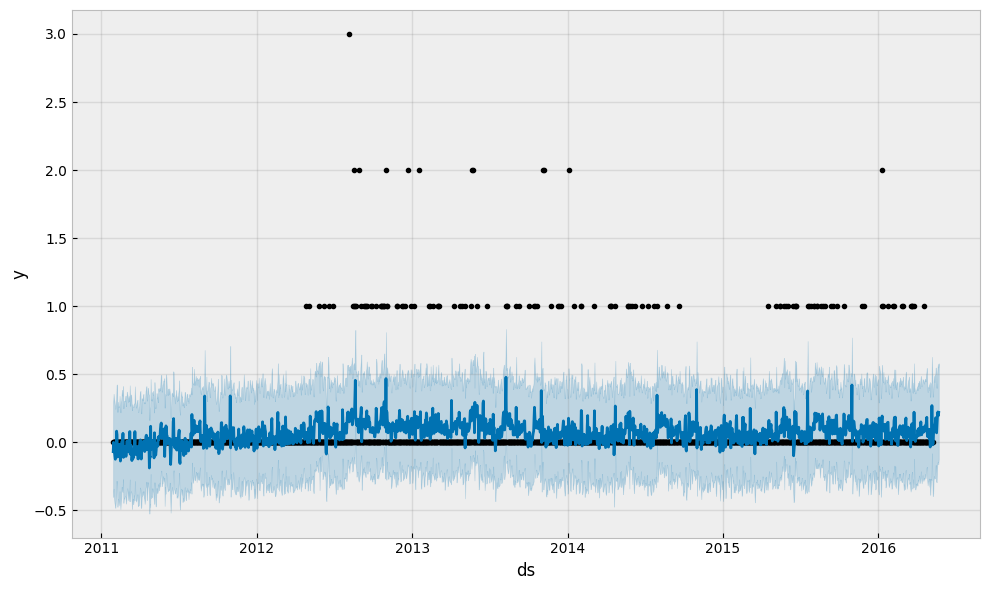

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:49:01 - cmdstanpy - INFO - Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


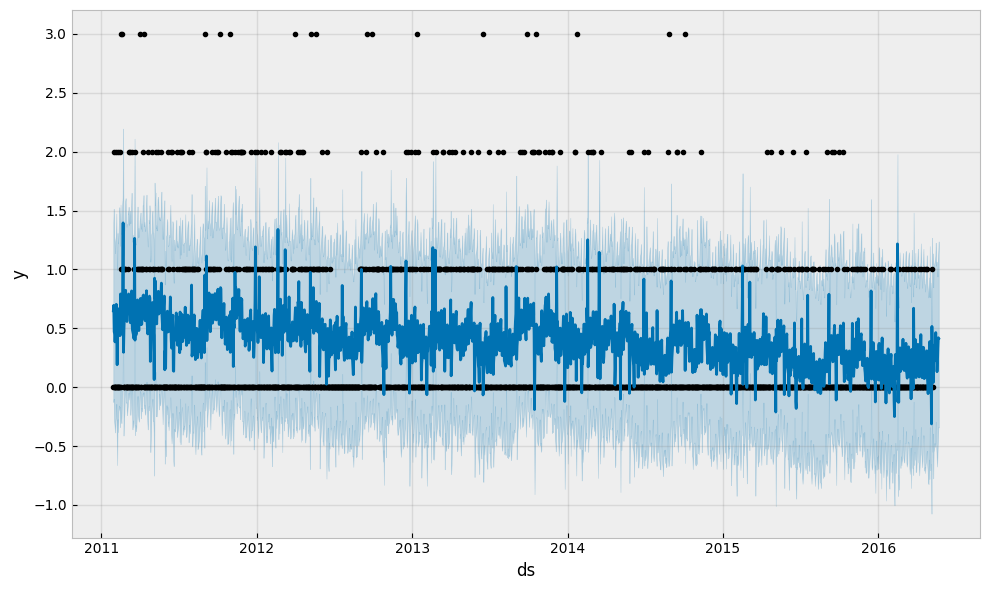

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:49:07 - cmdstanpy - INFO - Chain [1] start processing
22:49:07 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


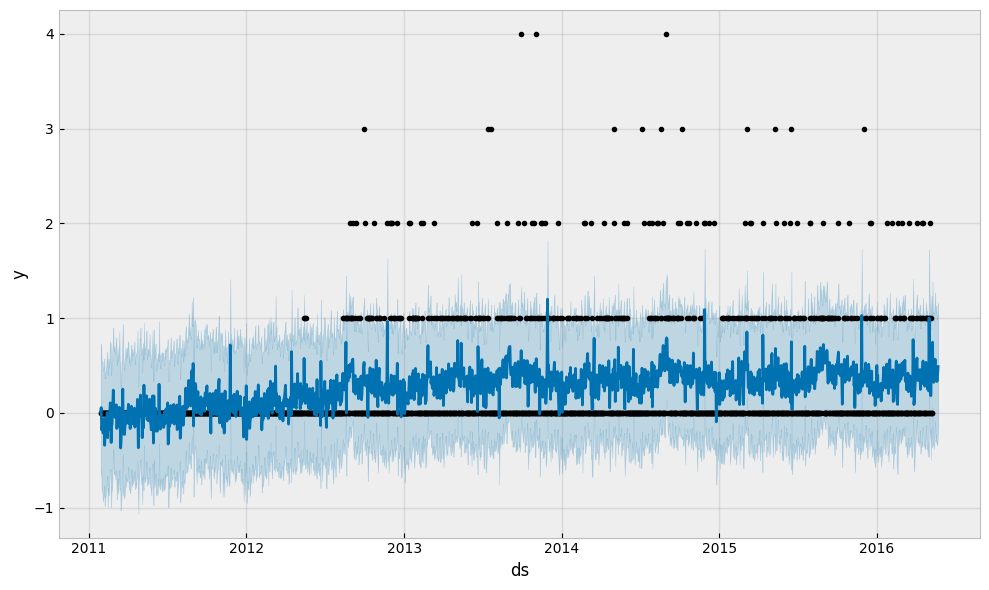

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:49:12 - cmdstanpy - INFO - Chain [1] start processing
22:49:13 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


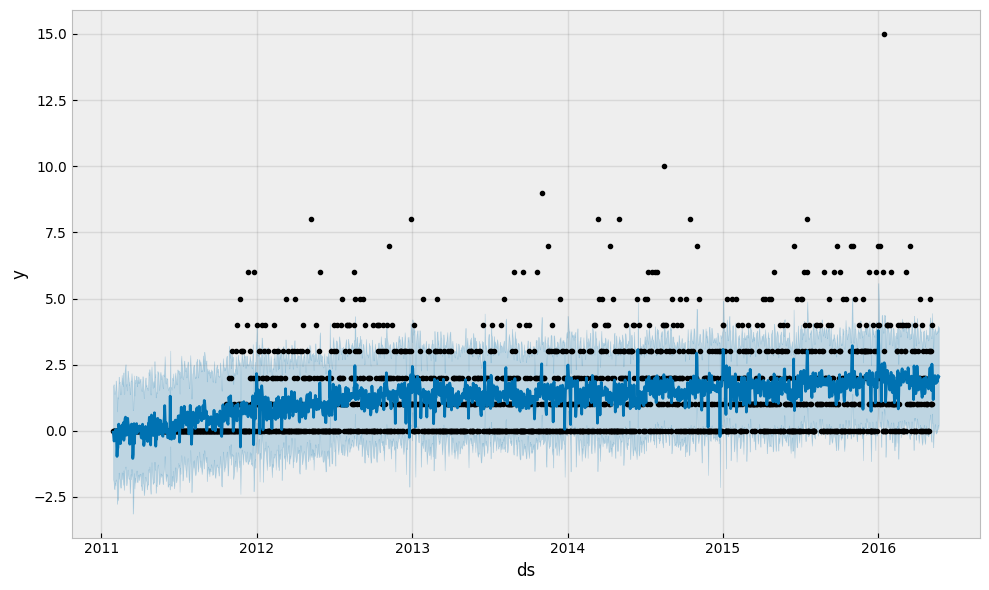

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  4  
1    

22:49:19 - cmdstanpy - INFO - Chain [1] start processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


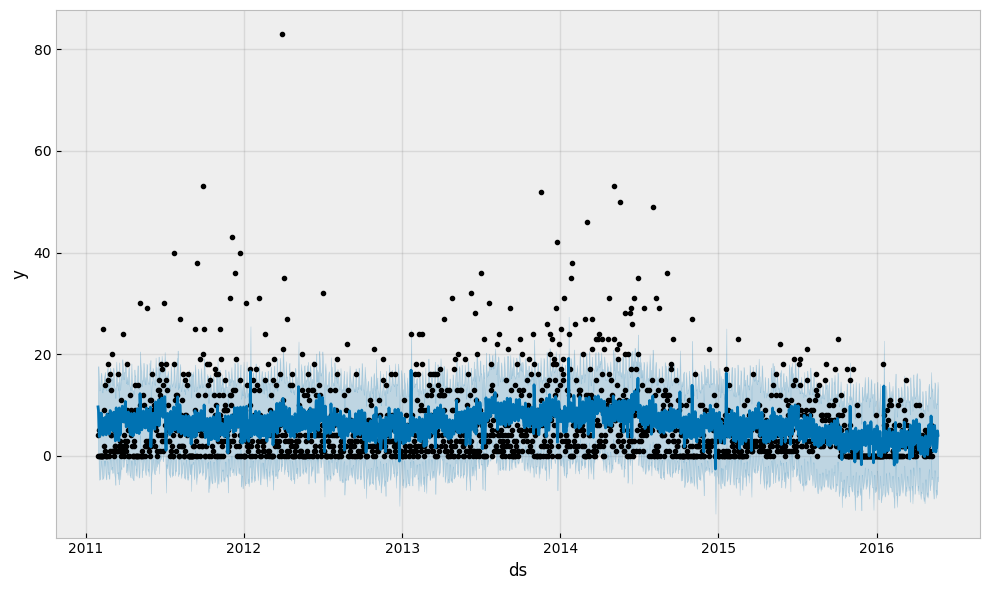

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2   y  
0             NaN   5  
1  

22:49:24 - cmdstanpy - INFO - Chain [1] start processing
22:49:24 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


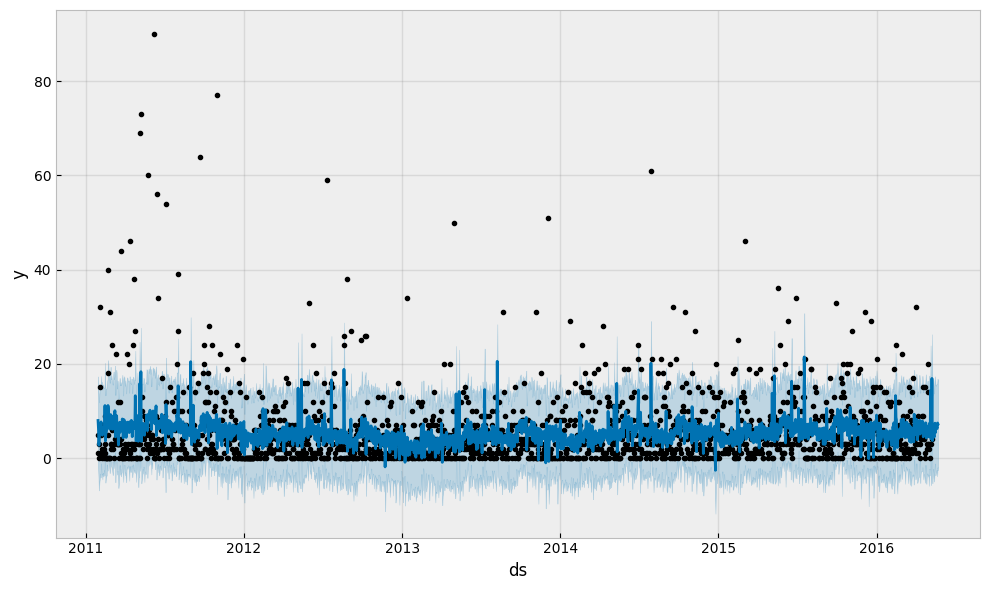

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:49:29 - cmdstanpy - INFO - Chain [1] start processing
22:49:30 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


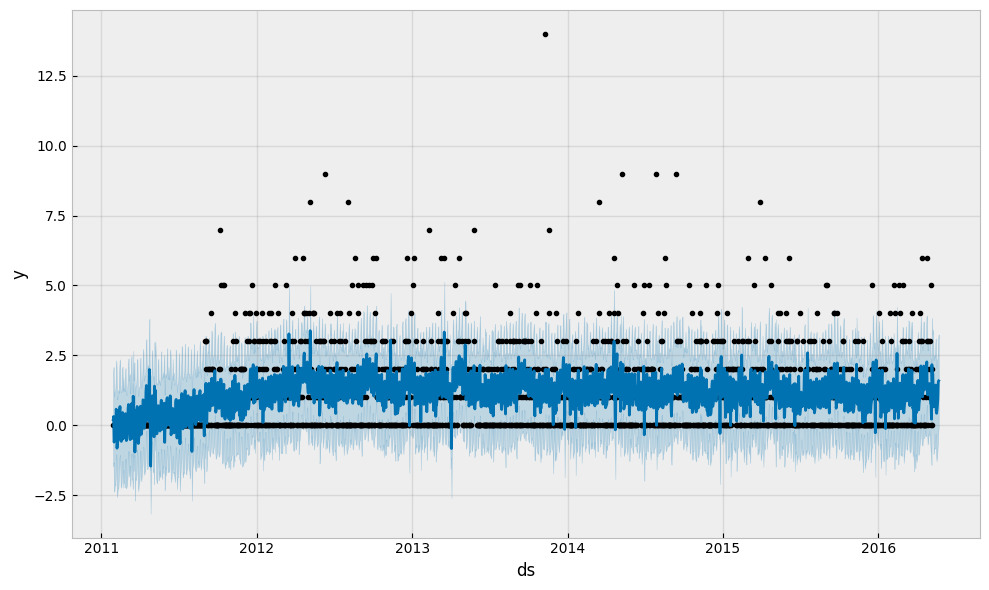

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:49:35 - cmdstanpy - INFO - Chain [1] start processing
22:49:35 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


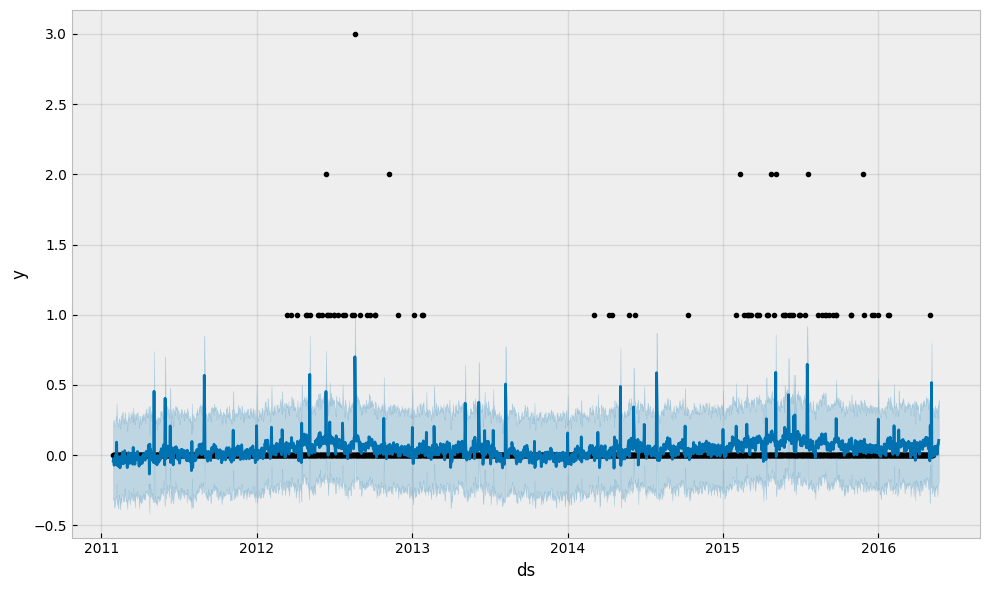

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2   y  
0             NaN   0  
1  

22:49:40 - cmdstanpy - INFO - Chain [1] start processing
22:49:41 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


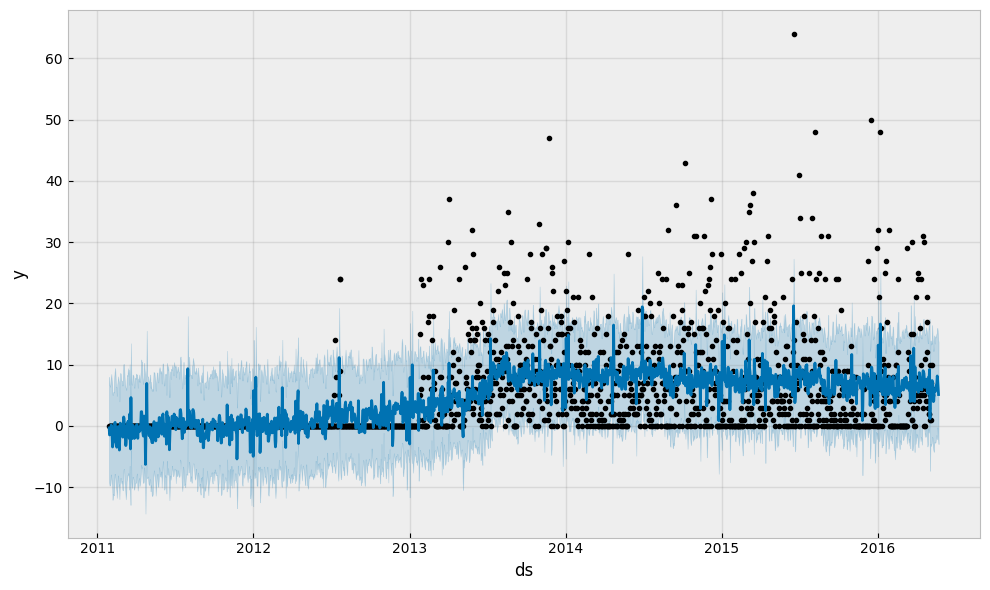

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:49:45 - cmdstanpy - INFO - Chain [1] start processing
22:49:46 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


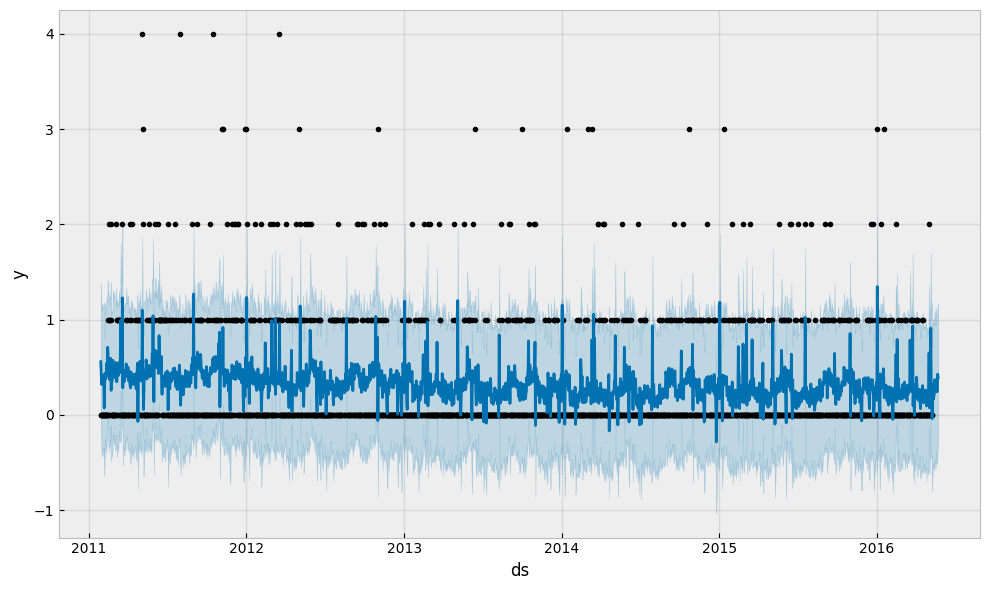

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:49:51 - cmdstanpy - INFO - Chain [1] start processing
22:49:52 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


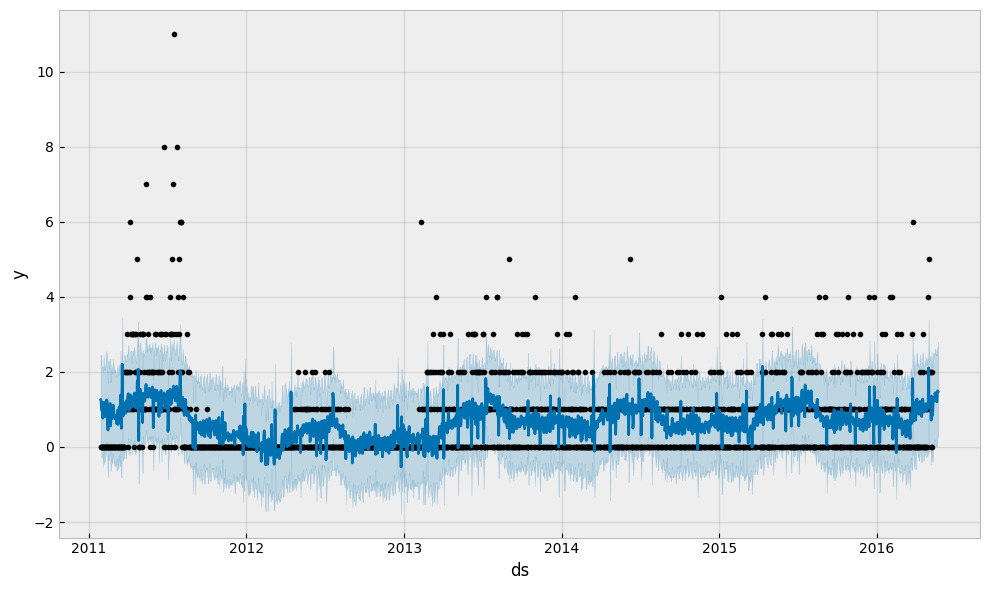

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  2  
1    

22:49:57 - cmdstanpy - INFO - Chain [1] start processing
22:49:57 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


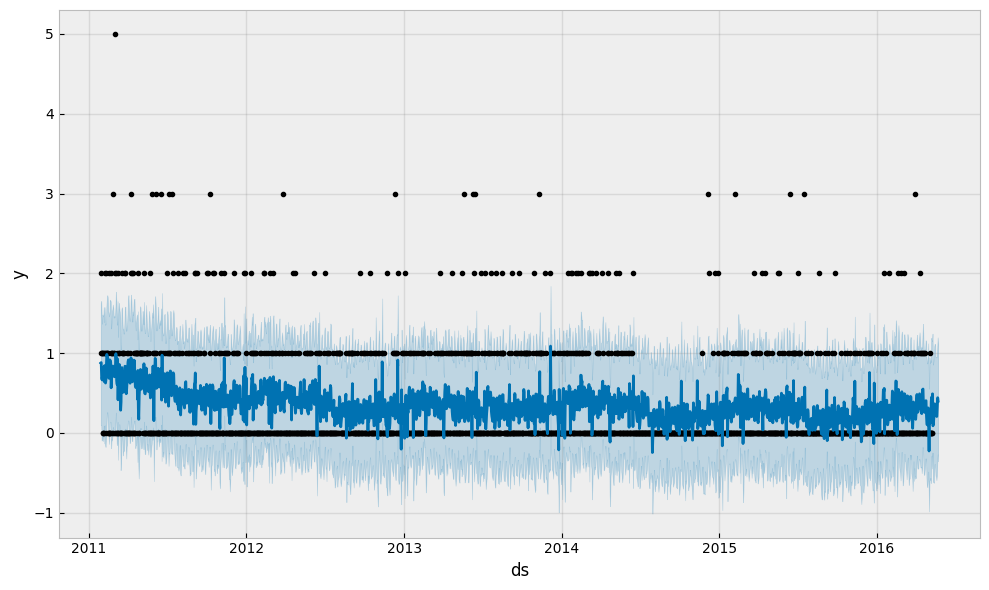

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  2  
1    

22:50:02 - cmdstanpy - INFO - Chain [1] start processing
22:50:03 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


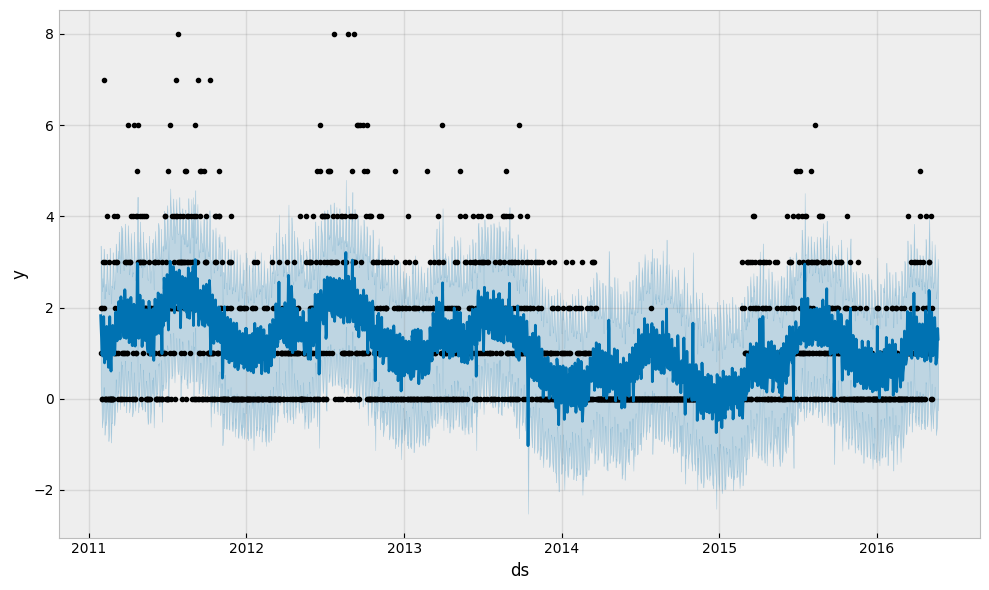

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:50:09 - cmdstanpy - INFO - Chain [1] start processing
22:50:10 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


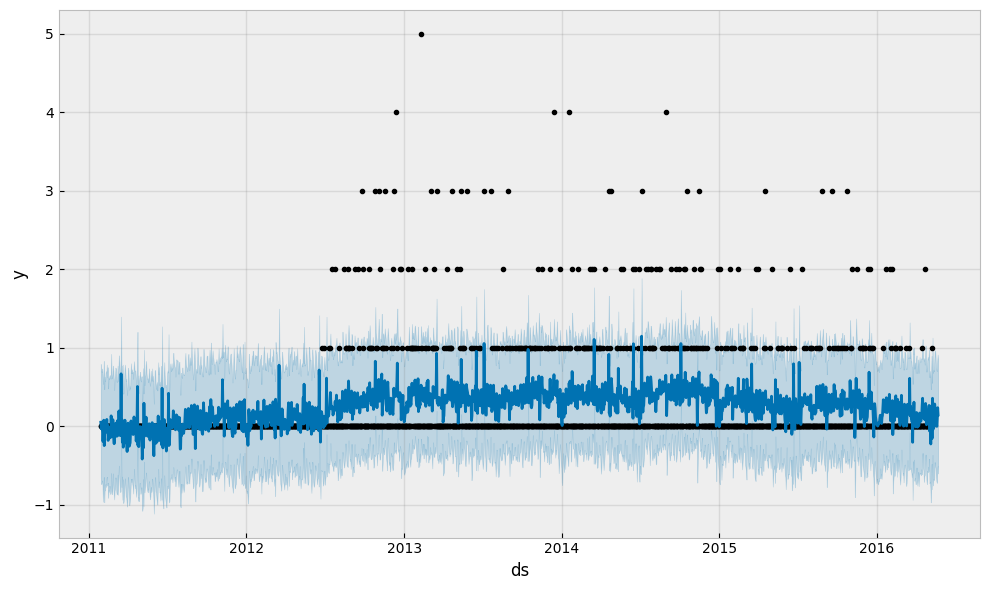

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:50:14 - cmdstanpy - INFO - Chain [1] start processing
22:50:14 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


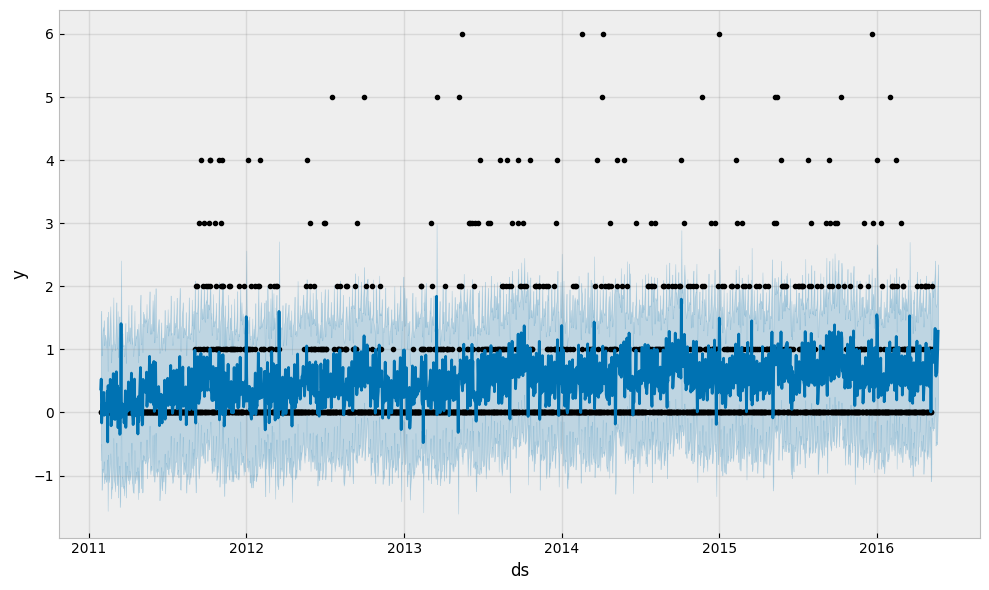

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:50:18 - cmdstanpy - INFO - Chain [1] start processing
22:50:19 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


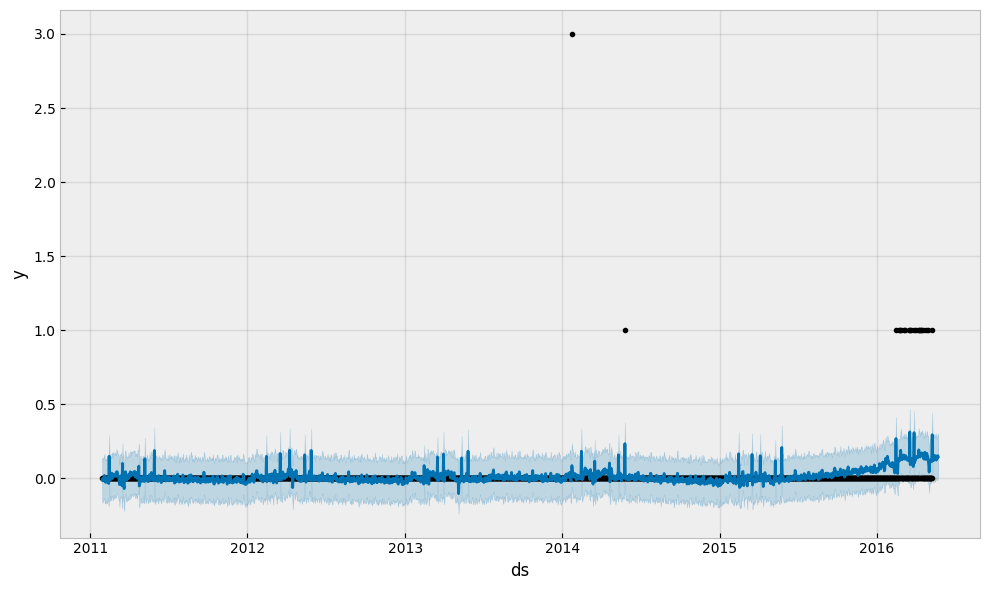

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:50:23 - cmdstanpy - INFO - Chain [1] start processing
22:50:23 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


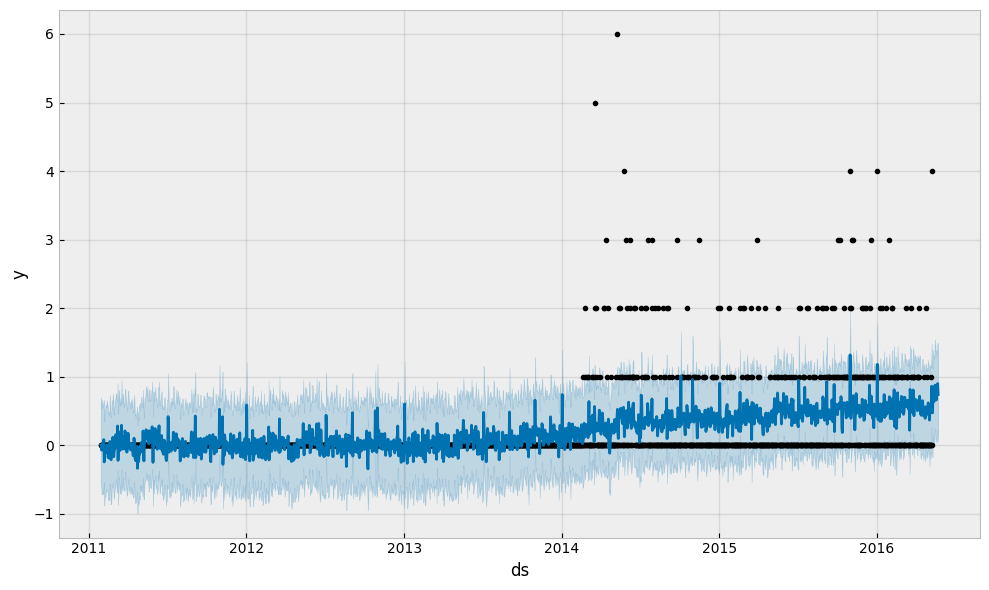

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:50:28 - cmdstanpy - INFO - Chain [1] start processing
22:50:28 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


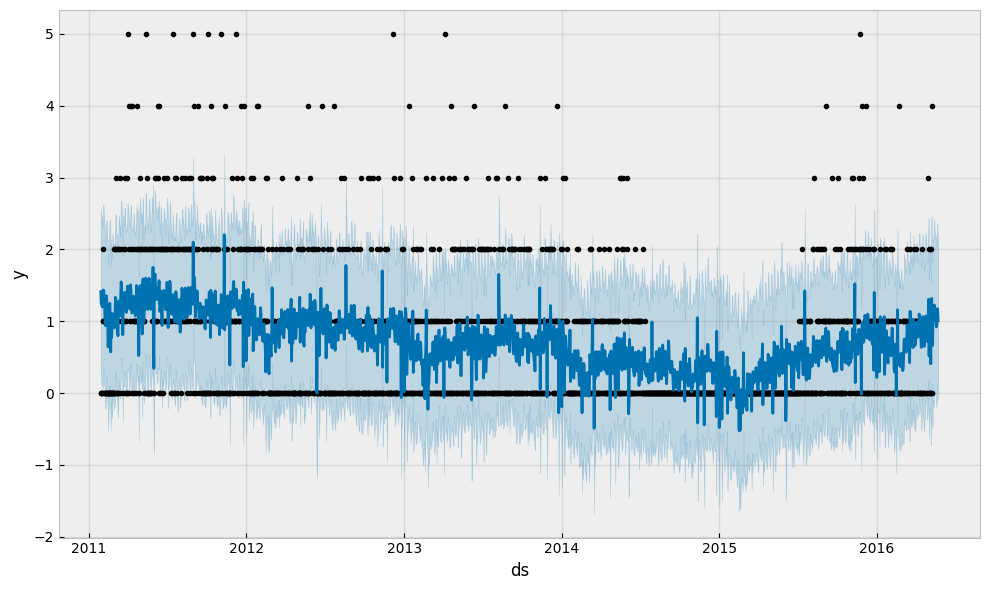

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  2  
1    

22:50:32 - cmdstanpy - INFO - Chain [1] start processing
22:50:33 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


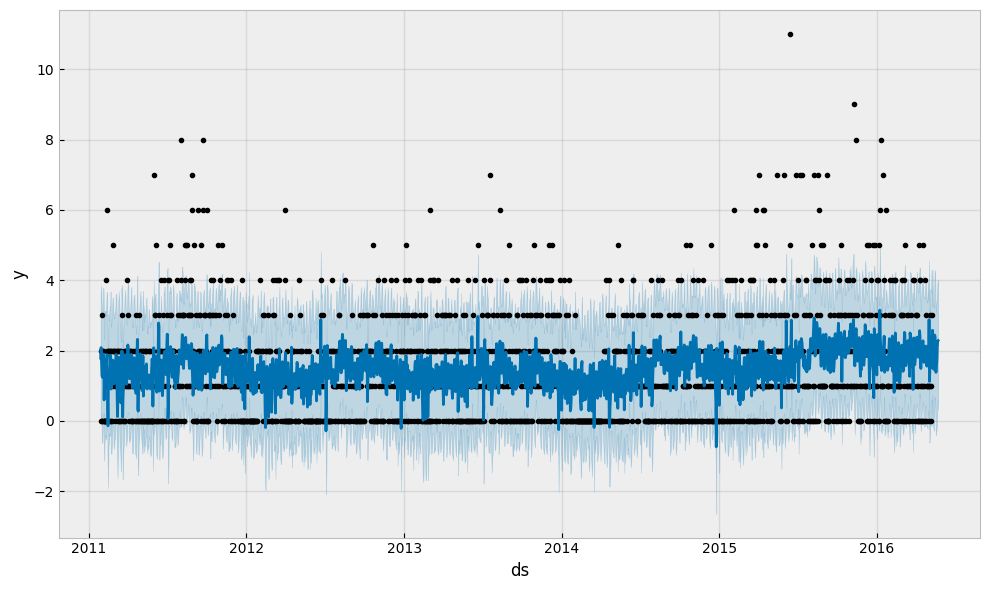

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2   y  
0             NaN   0  
1  

22:50:37 - cmdstanpy - INFO - Chain [1] start processing
22:50:38 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


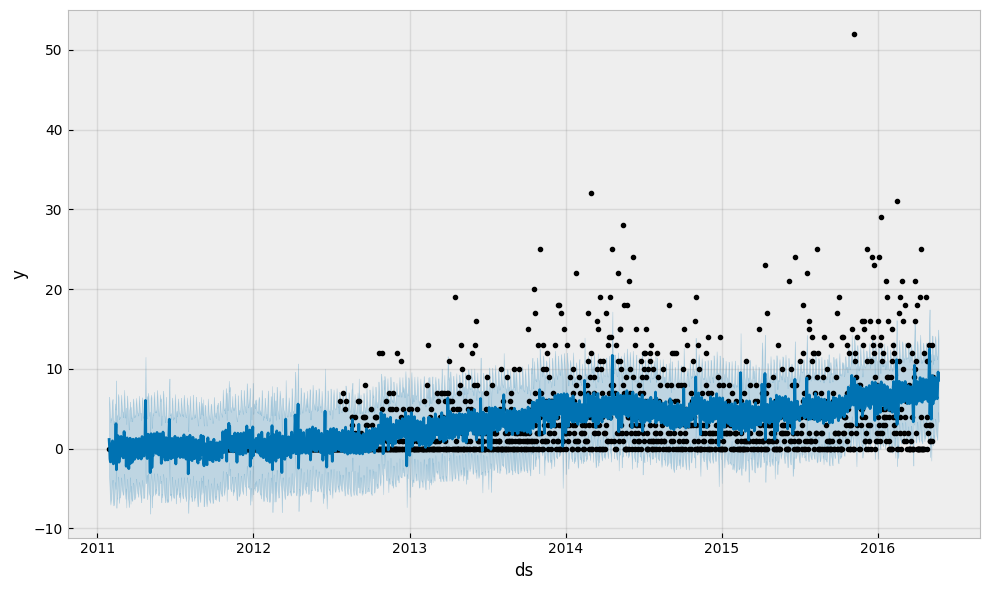

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:50:46 - cmdstanpy - INFO - Chain [1] start processing
22:50:46 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


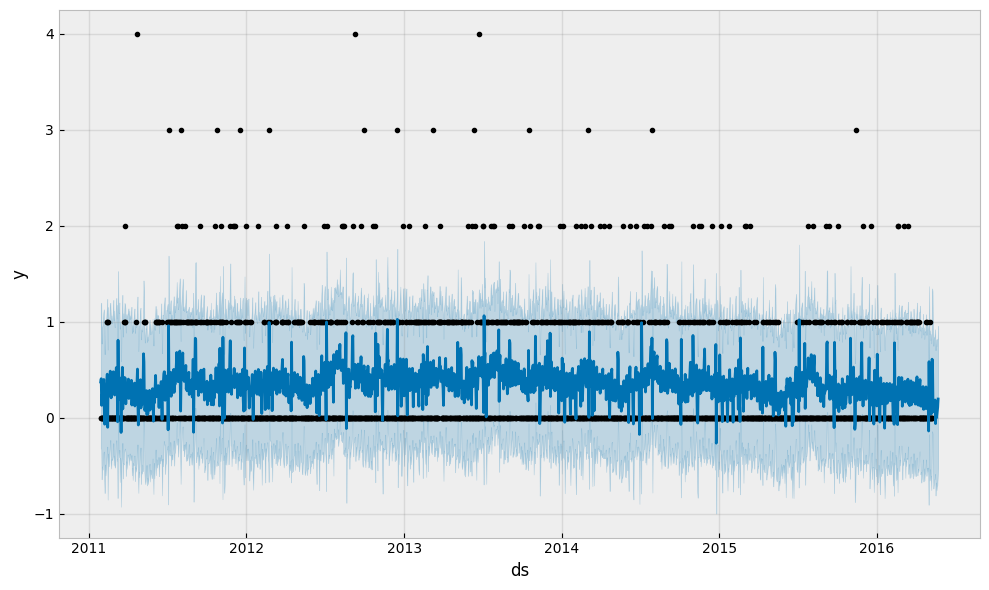

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2   y  
0             NaN   9  
1  

22:50:53 - cmdstanpy - INFO - Chain [1] start processing
22:50:53 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


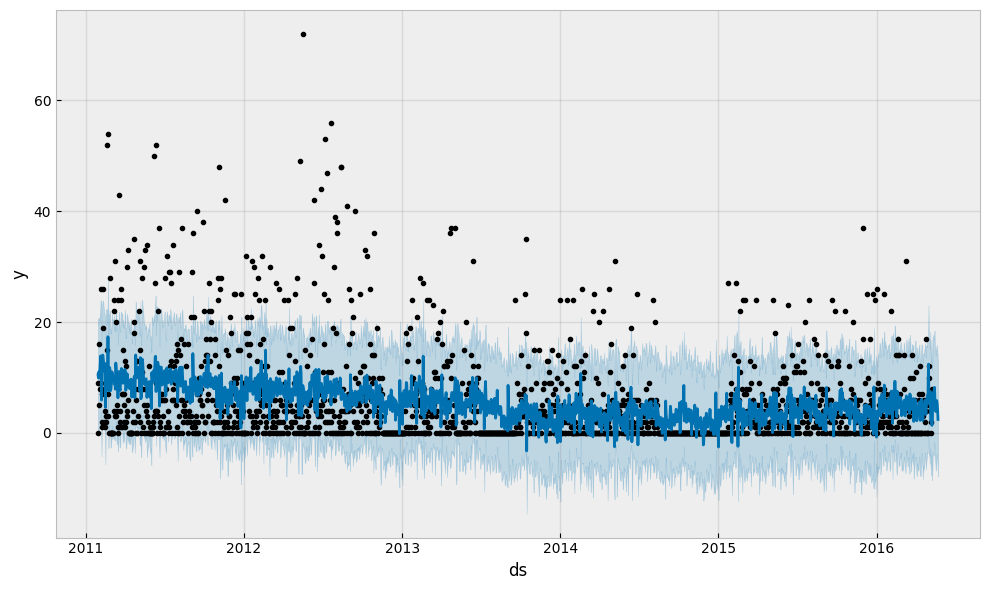

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:50:59 - cmdstanpy - INFO - Chain [1] start processing
22:51:00 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


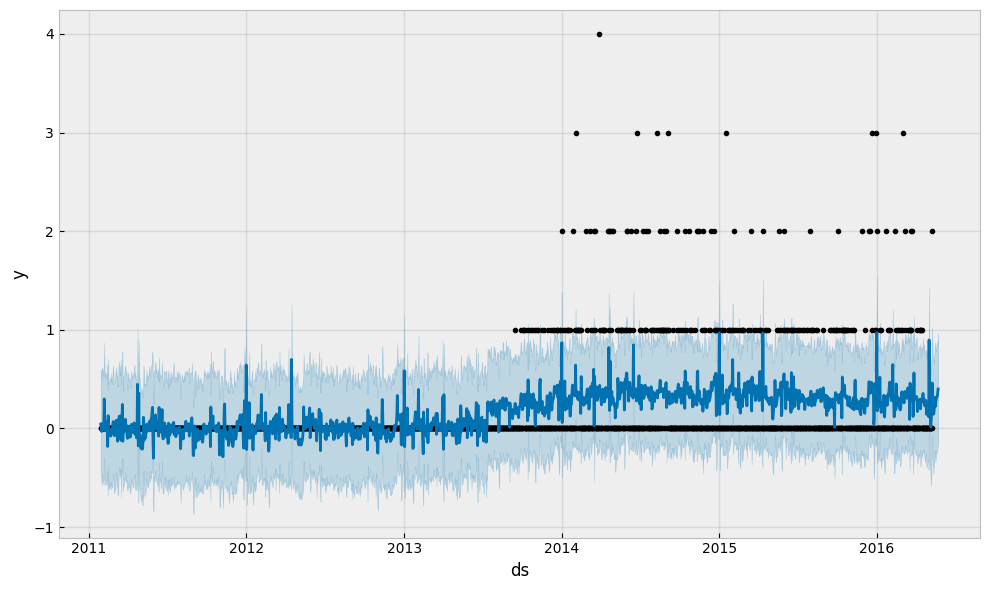

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:51:06 - cmdstanpy - INFO - Chain [1] start processing
22:51:07 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


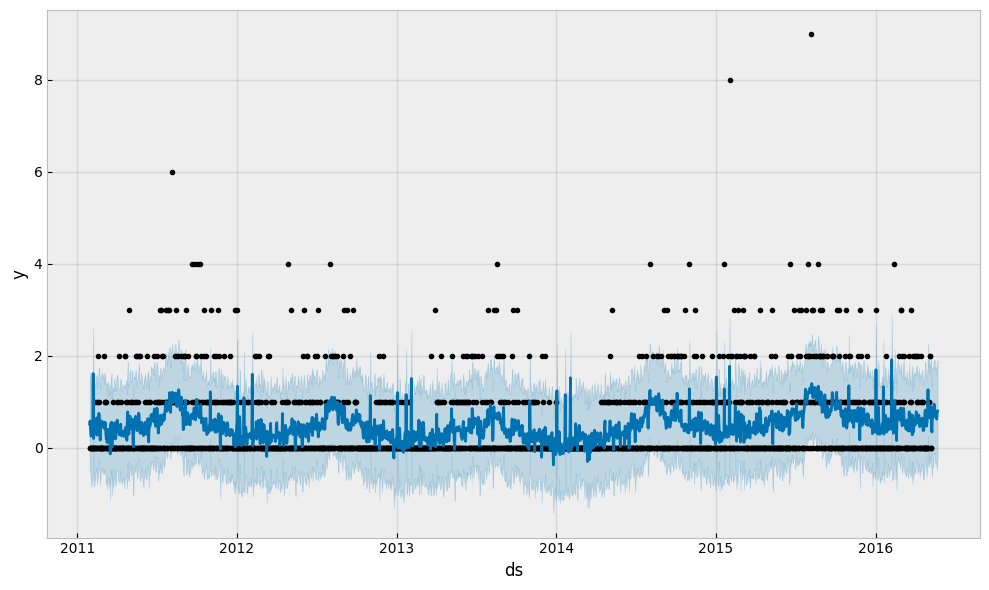

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:51:13 - cmdstanpy - INFO - Chain [1] start processing
22:51:13 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


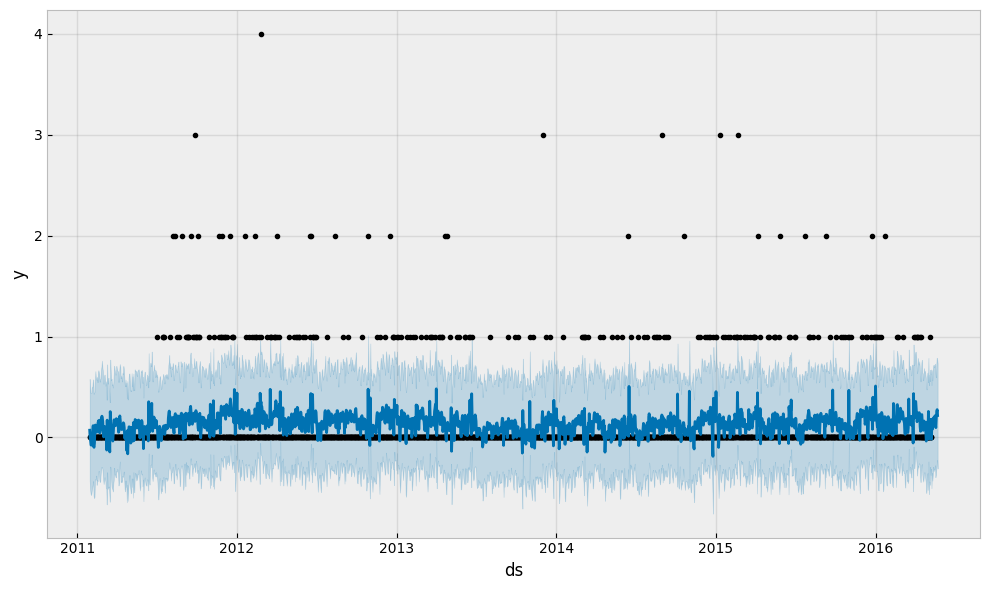

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  2  
1    

22:51:20 - cmdstanpy - INFO - Chain [1] start processing
22:51:21 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


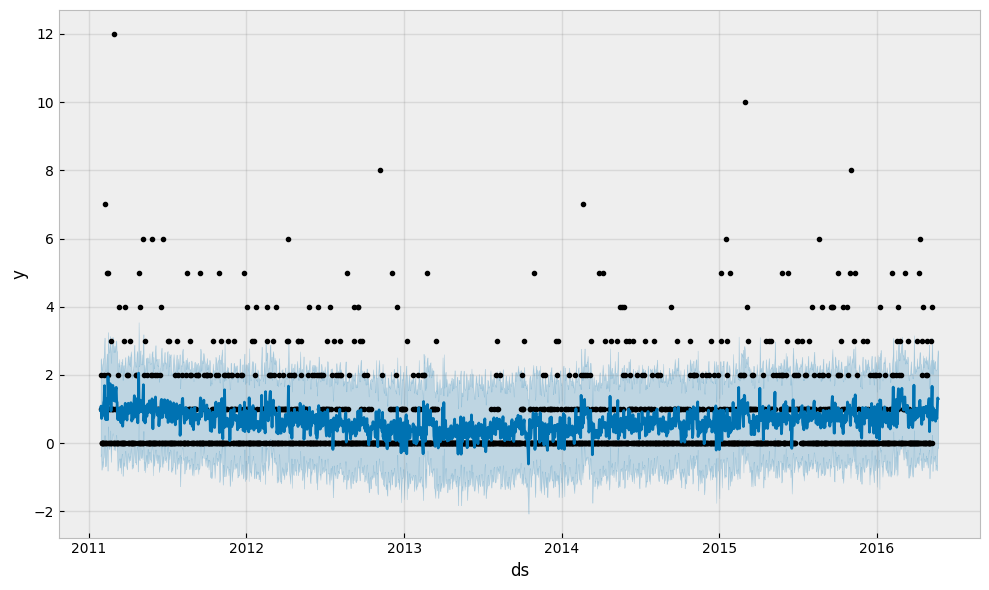

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:51:27 - cmdstanpy - INFO - Chain [1] start processing
22:51:28 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


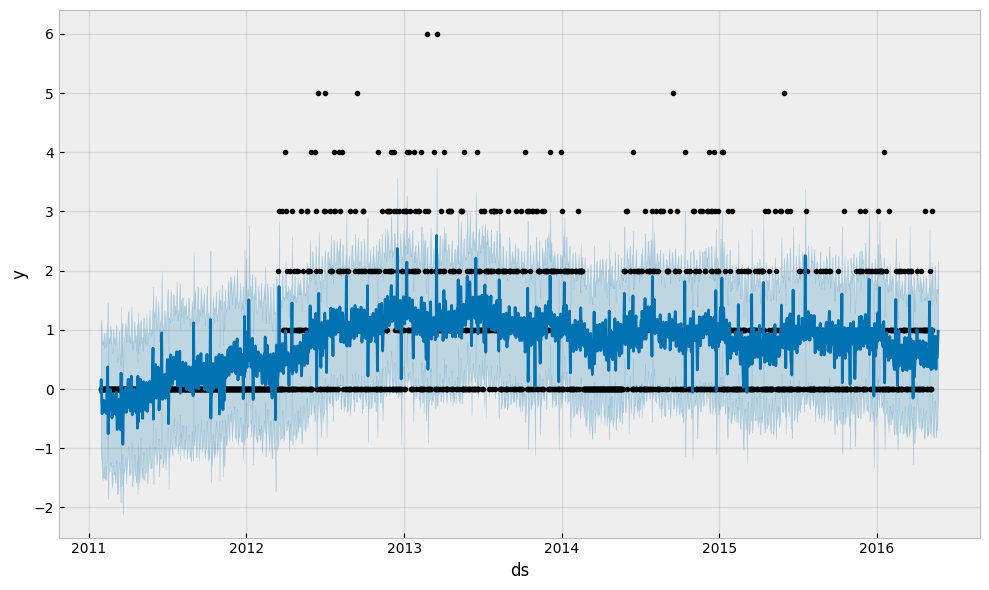

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:51:34 - cmdstanpy - INFO - Chain [1] start processing
22:51:35 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+10
3    2011-02-01     11101  1.000000e+10
4    2011-02-02     11101  1.000000e+10
...         ...       ...           ...
1936 2016-05-18     11616  8.380000e+00
1937 2016-05-19     11616  8.380000e+00
1938 2016-05-20     11616  8.380000e+00
1939 2016-05-21     11617  8.380000e+00
1940 2016-05-22     11617  8.380000e+00

[1941 rows x 3 columns]
             ds  wm_yr_wk    sell_price
0    2011-01-29     11101  1.000000e+10
1    2011-01-30     11101  1.000000e+10
2    2011-01-31     11101  1.000000e+1

/usr/local/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


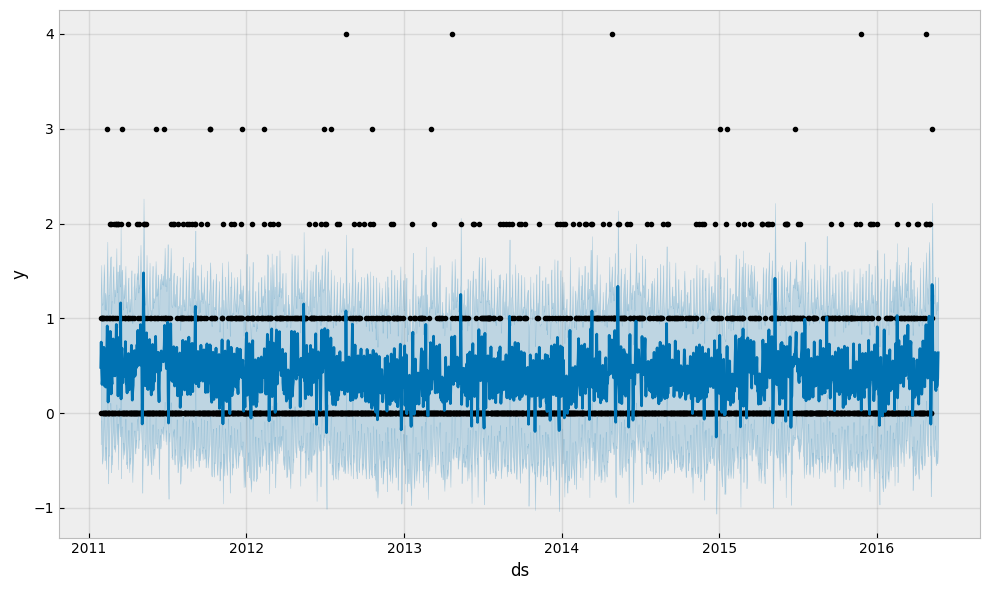

/var/folders/xq/5x1ctvtx1mx1dtxfs8h7l4d80000gn/T/ipykernel_3190/1317163612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


            date       d  wm_yr_wk   event_name_1 event_type_1 event_name_2  \
0     2011-01-29     d_1     11101            NaN          NaN          NaN   
1     2011-01-30     d_2     11101            NaN          NaN          NaN   
2     2011-01-31     d_3     11101            NaN          NaN          NaN   
3     2011-02-01     d_4     11101            NaN          NaN          NaN   
4     2011-02-02     d_5     11101            NaN          NaN          NaN   
...          ...     ...       ...            ...          ...          ...   
1922  2016-05-04  d_1923     11614            NaN          NaN          NaN   
1923  2016-05-05  d_1924     11614  Cinco De Mayo     Cultural          NaN   
1924  2016-05-06  d_1925     11614            NaN          NaN          NaN   
1925  2016-05-07  d_1926     11615            NaN          NaN          NaN   
1926  2016-05-08  d_1927     11615   Mother's day     Cultural          NaN   

     event_type_2  y  
0             NaN  0  
1    

22:51:42 - cmdstanpy - INFO - Chain [1] start processing
22:51:43 - cmdstanpy - INFO - Chain [1] done processing


             ds  wm_yr_wk
0    2011-01-29     11101
1    2011-01-30     11101
2    2011-01-31     11101
3    2011-02-01     11101
4    2011-02-02     11101
...         ...       ...
1936 2016-05-18     11616
1937 2016-05-19     11616
1938 2016-05-20     11616
1939 2016-05-21     11617
1940 2016-05-22     11617

[1941 rows x 2 columns]


KeyboardInterrupt: 

In [15]:
for i in range(train.shape[0]):
    df = pd.DataFrame(calendar[['date', 'd', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']])
    df_train =  df.loc[0:1926]
    df_test = df.loc[1927:]

    df_train['y'] = train.loc[i,'d_1':].values
    print(df_train)
    df_train = pd.merge(df_train, price[(price['store_id'] == train.loc[i,'store_id']) \
                & (price['item_id'] == train.loc[0,'item_id'])]\
                [['wm_yr_wk', 'sell_price']], how='left', on=['wm_yr_wk'])
    
    df_train = df_train.rename(columns={'date': 'ds'})

    print(df_train)
    df_train = df_train.fillna({"sell_price":9999999999})
    print("-------------------")
    print(df_train)
    print("-------------------")
    
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays=holidays)
    # model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    model.add_seasonality(name="monthly", period=30.5, fourier_order=7)
    model.add_seasonality(name="yearly", period=365, fourier_order=10)
    
    model.add_regressor('sell_price')
    model.fit(df_train)
    future = model.make_future_dataframe(periods=14)
    future["wm_yr_wk"] = calendar[:len(future)]["wm_yr_wk"]
    #future = future.rename(columns={'ds': 'date'})
    print(future)
   
    future = pd.merge(future, price[(price['store_id'] == train.loc[i,'store_id'])\
                    & (price['item_id'] == train.loc[0,'item_id'])] \
                    [['wm_yr_wk',"sell_price"]], how='left', on=['wm_yr_wk'])
    future = future.fillna({"sell_price":9999999999})
    print(future)
    #future["sell_price"] = df_train["sell_price"]
    print(future)
    forecast = model.predict(future)
    #print(forecast.tail(14))
    #model.plot(forecast.tail(14))
    model.plot(forecast)
    plt.show()
    #df_train.to_csv('df_train' + str(i) + '.csv', index=False)